In [1]:
%config IPCompleter.greedy=True 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import code_two_states.generation_sequences as ge 
import cython_code.analyse_sequence as an
import codes.inference_partners_generated_data as inf_partner
import codes.random_fasta as rdf
import codes.generation_sequence_arDCA as ge_arDCA
import codes.generation_sequence_bmDCA as ge_bmDCA
import subprocess
import codes.utility_plot as uti
import codes.utility_plot_freq as ut

########## ASPECT #################
width = "article"
width_pt = 430.00462

cmaps = np.array([(64, 83, 211), (221, 179, 16), (181, 29, 20), (0, 190, 255), (251, 73, 176), (0, 178, 93), (202, 202, 202), (0, 0, 0)])/255 # http://tsitsul.in/blog/coloropt/
l = [1, 0, 5, 2, 4, 3, 6, 7]
cmaps = cmaps[l]
sns.set_theme(context='notebook', style='ticks', palette=cmaps, color_codes=True, rc=None)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "arial",
    # Use 10pt font in plots, to maT_ch 10pt font in document
    "font.size": 10,
    "axes.titlesize" : 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth" : 1.3,
    'axes.linewidth' : 1,
}
plt.rcParams.update(tex_fonts)
########## ASPECT #################


n_generations = 10 # 2^10 = 1024 chain of spin
n_mutations_branch = 15
n_avg = 10

Flip_equi = 100000
n_sequences_no_phylo = 2**n_generations

T = 5.0

s_train = 400
theta = 0.0
pseudo_count = 0.5
n_pair_species = 4

save = False ## Regenerete new data and infer on it with bmDCA

label_0 = "Contacts only"
label_1 = "Phylo rand."
label_2 = "Contacts & phylogeny"
label_3 = "Phylogeny only"
label_4 = "Null model"
ylabel = "Correct prediction fraction"
ls_4 = "dotted"
ls_real_model = "--"

/home/andonis/.local/lib/python3.8/site-packages/seaborn/palettes.py:1021: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette == "reset":


# Generating Data
## Graph

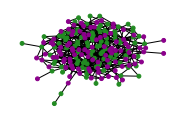

In [2]:
start_new_graph = False
if start_new_graph:
    N = 200 #Number of node in the graph 200 Nicola
    p = 0.02 ##proba two nodes connected 
    Graph =nx.erdos_renyi_graph(N,p)
    nx.write_gexf(Graph,"graphes/Graph_Erdos")

Graph = nx.read_gexf("graphes/Graph_Erdos",node_type=int)
figsize = uti.set_size(width,subplots=(1,1),fraction=0.4)
plt.figure(figsize=figsize)
nx.draw_kamada_kawai(Graph,with_labels=False , node_size=15, node_color=["forestgreen" for node in range(len(Graph.nodes())//2)] + ["darkmagenta" for node in range(len(Graph.nodes())//2)])
#plt.savefig("figures_two_states/Graph.eps")

In [3]:
n_seq = int(2**n_generations)
sampling = ge.Sampling_msa_two_states(Graph)
sampling.T = T

msa_no_phylo = sampling.msa_no_phylo(n_seq)
msa_binary_tree_equi = sampling.msa_binary_tree(n_generations, n_mutations_branch, 1)

def convert_msa_to_int(msa):
    msa = (msa + 1)/2
    return np.array(msa, dtype=np.int8)

msa_no_phylo = convert_msa_to_int(msa_no_phylo)
msa_binary_tree_equi = convert_msa_to_int(msa_binary_tree_equi)

if save==True:
    print("Save new data")
    np.save("data_genereted_after_inference/msa_no_phylo", msa_no_phylo)
    np.save("data_genereted_after_inference/msa_binary_tree_equi", msa_binary_tree_equi)

Standard Temperature is 1.0
Number of flip to reach equilibrium is 4000


## Save at fasta file format
### arDCA

In [4]:
folder = "data_ardca/"
alphabet = "AC" ##First two letter of alphabet used in arDCA

file_name_no_phylo = folder + "msa_no_phylo.fasta"
file_name_phylo = folder + "msa_phylo.fasta"

if save==True:
    print("Save new data")
    rdf.write_msa_to_fasta(msa_no_phylo,  file_name_no_phylo, alphabet)
    rdf.write_msa_to_fasta(msa_binary_tree_equi, file_name_phylo, alphabet)

### bmDCA

In [5]:
#folder_old_bmdca = "bmDCA_2_states/"
folder = "bmdca_new/"
alphabet = "-A" #First two letter of alphabet used in bmDCA

file_name_no_phylo = folder + "msa_no_phylo.fasta"
file_name_phylo = folder + "msa_phylo.fasta"

if save==True:
    print("Save new data")
    rdf.write_msa_to_fasta(msa_no_phylo,  file_name_no_phylo, alphabet)
    rdf.write_msa_to_fasta(msa_binary_tree_equi, file_name_phylo, alphabet)

# Inference
## Inference with bmDCA

Two choice :

- (fastest choice) install https://github.com/ranganathanlab/bmDCA and launch the following jupyter cells
    or
  
- Open a terminal in the folder Phylogeny_Partners_gene_inf and do : `bash bmdca_inference.sh msa_phylo.fasta msa_no_phylo.fasta`

In [6]:
def infer_field_bmdca(fasta_file):
    
    directory_result = fasta_file[:-6] 
    
    try:
        normal =  subprocess.run("rm -R %s"%directory_result, capture_output=True, shell=True)
    except Exception as e:
        print(e)
        
    try:
        normal =  subprocess.run("mkdir %s"%directory_result, capture_output=True, shell=True)
    except Exception as e:
        print(e)
    
    config = "bmdca_new/" + "bmdca.conf"
    cmd = "bmdca -i %s -c %s -d %s -r"%(fasta_file, config, directory_result)
    normal =  subprocess.run(cmd, capture_output=True, shell=True)

    cmd = "arma2ascii -p %s -P %s"%(directory_result + "/parameters_h_final.bin",  directory_result + "/parameters_J_final.bin")
    normal =  subprocess.run(cmd, capture_output=True, shell=True)
    print(normal)

if save:
    print("Save new data")
    infer_field_bmdca(file_name_no_phylo)
    infer_field_bmdca(file_name_phylo)

## Inference with arDCA  !!!! Run the jupyter notebook written in Julia Inference_arDCA.ipynb !!!!!

 !!!! Run the jupyter notebook written in Julia Inference_arDCA.ipynb !!!!!

# Generation of data with inferred parameters
## bmDCA

In [7]:
!cythonize -i cython_code/generation_sequence.pyx
!cythonize -i cython_code/generation_sequence_arDCA.pyx

running build_ext
running build_ext


In [8]:
if save==True:
    ## If you used bmdca_inference.sh
      #path_file_coupling = "bmDCA_2_states/OutputFolder_msa_no_phylo.fasta/parameters_learnt_2000.txt"
    ## Or for https://github.com/ranganathanlab/bmDCA 
    path_file_coupling = file_name_no_phylo[:-6] + "/parameters_final.txt"
    
    path_save_msa = "data_genereted_after_inference/msa_infered_no_phylo_bmDCA.fasta"
    ge_bmDCA.generate_sequences_bmDCA(path_file_coupling, path_save_msa, Flip_equi, n_sequences_no_phylo)

    path_save_msa = "data_genereted_after_inference/msa_phylo_infered_no_phylo_bmDCA.fasta"
    ge_bmDCA.generate_sequences_bmDCA_phylo(path_file_coupling, path_save_msa, n_generations, n_mutations_branch, Flip_equi)


    #path_file_coupling = "bmDCA_2_states/OutputFolder_msa_phylo.fasta/parameters_learnt_2000.txt"
    path_file_coupling = file_name_phylo[:-6] + "/parameters_final.txt"
    path_save_msa = "data_genereted_after_inference/msa_infered_phylo_bmDCA.fasta"
    ge_bmDCA.generate_sequences_bmDCA(path_file_coupling, path_save_msa, Flip_equi, n_sequences_no_phylo)

    path_save_msa = "data_genereted_after_inference/msa_phylo_infered_phylo_bmDCA.fasta"
    ge_bmDCA.generate_sequences_bmDCA_phylo(path_file_coupling, path_save_msa, n_generations, n_mutations_branch, Flip_equi)


## arDCA

In [9]:
path_folder_coupling = "data_ardca/"
n_sequences_no_phylo = 2**n_generations

if save==True:
    name_msa = "msa_no_phylo"

    path_save_msa = "data_genereted_after_inference/msa_infered_no_phylo_arDCA.fasta"
    ge_arDCA.generate_sequences_arDCA(path_folder_coupling, name_msa, path_save_msa, n_sequences_no_phylo)

    path_save_msa = "data_genereted_after_inference/msa_phylo_infered_no_phylo_arDCA.fasta"
    ge_arDCA.generate_sequences_arDCA_phylo(path_folder_coupling, name_msa, path_save_msa, n_generations, n_mutations_branch, 1)


    name_msa = "msa_phylo"

    path_save_msa = "data_genereted_after_inference/msa_infered_phylo_arDCA.fasta"
    ge_arDCA.generate_sequences_arDCA(path_folder_coupling, name_msa, path_save_msa, n_sequences_no_phylo)

    path_save_msa = "data_genereted_after_inference/msa_phylo_infered_phylo_arDCA.fasta"
    ge_arDCA.generate_sequences_arDCA_phylo(path_folder_coupling, name_msa, path_save_msa, n_generations, n_mutations_branch, 1)

# Inference of partners

In [10]:
msa_no_phylo = np.load("data_genereted_after_inference/msa_no_phylo.npy")
msa_binary_tree_equi = np.load("data_genereted_after_inference/msa_binary_tree_equi.npy")

## arDCA ##
path_save_msa = "data_genereted_after_inference/msa_infered_no_phylo_arDCA.fasta.npy"
msa_infered_no_phylo_arDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_infered_phylo_arDCA.fasta.npy"
msa_infered_phylo_arDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_phylo_infered_no_phylo_arDCA.fasta.npy"
msa_phylo_infered_no_phylo_arDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_phylo_infered_phylo_arDCA.fasta.npy"
msa_phylo_infered_phylo_arDCA = np.load(path_save_msa)

## bmDCA ##
path_save_msa = "data_genereted_after_inference/msa_infered_no_phylo_bmDCA.fasta.npy"
msa_infered_no_phylo_bmDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_infered_phylo_bmDCA.fasta.npy"
msa_infered_phylo_bmDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_phylo_infered_no_phylo_bmDCA.fasta.npy"
msa_phylo_infered_no_phylo_bmDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_phylo_infered_phylo_bmDCA.fasta.npy"
msa_phylo_infered_phylo_bmDCA = np.load(path_save_msa)


In [11]:
size_train_max = int(1.5*2**(n_generations-1))
regularisation = pseudo_count
number_of_pair_in_species = n_pair_species
n_state_spin = 2
middle_index = 100
theta = 0

l_size_train = np.unique(np.geomspace(1, size_train_max, num=30, dtype=int))
args = [l_size_train, number_of_pair_in_species, 
        regularisation, n_state_spin, middle_index, theta]

l_infered_no_phylo, l_infered_no_phylo_Jij = inf_partner.l_plot_inference(msa_no_phylo, *args)

l_infered_phylo, l_infered_phylo_Jij = inf_partner.l_plot_inference(msa_binary_tree_equi, *args)

## arDCA ##
l_infered_no_phylo_arDCA, l_infered_no_phylo_arDCA_Jij = inf_partner.l_plot_inference(msa_infered_no_phylo_arDCA, *args)

l_infered_phylo_arDCA, l_infered_phylo_arDCA_Jij = inf_partner.l_plot_inference(msa_infered_phylo_arDCA, *args)

l_phylo_infered_no_phylo_arDCA, l_phylo_infered_no_phylo_arDCA_Jij = inf_partner.l_plot_inference(msa_phylo_infered_no_phylo_arDCA, *args)

l_phylo_infered_phylo_arDCA, l_phylo_infered_phylo_arDCA_Jij = inf_partner.l_plot_inference(msa_phylo_infered_phylo_arDCA, *args)

## bmDCA ##
l_infered_no_phylo_bmDCA, l_infered_no_phylo_bmDCA_Jij = inf_partner.l_plot_inference(msa_infered_no_phylo_bmDCA, *args)

l_infered_phylo_bmDCA, l_infered_phylo_bmDCA_Jij = inf_partner.l_plot_inference(msa_infered_phylo_bmDCA, *args)

l_phylo_infered_no_phylo_bmDCA, l_phylo_infered_no_phylo_bmDCA_Jij = inf_partner.l_plot_inference(msa_phylo_infered_no_phylo_bmDCA, *args)

l_phylo_infered_phylo_bmDCA, l_phylo_infered_phylo_bmDCA_Jij = inf_partner.l_plot_inference(msa_phylo_infered_phylo_bmDCA, *args)

0.0  %
19.230769230769234  %
38.46153846153847  %
57.692307692307686  %
76.92307692307693  %
96.15384615384616  %
0.0  %
19.230769230769234  %
38.46153846153847  %
57.692307692307686  %
76.92307692307693  %
96.15384615384616  %
0.0  %
19.230769230769234  %
38.46153846153847  %
57.692307692307686  %
76.92307692307693  %
96.15384615384616  %
0.0  %
19.230769230769234  %
38.46153846153847  %
57.692307692307686  %
76.92307692307693  %
96.15384615384616  %
0.0  %
19.230769230769234  %
38.46153846153847  %
57.692307692307686  %
76.92307692307693  %
96.15384615384616  %
0.0  %
19.230769230769234  %
38.46153846153847  %
57.692307692307686  %
76.92307692307693  %
96.15384615384616  %
0.0  %
19.230769230769234  %
38.46153846153847  %
57.692307692307686  %
76.92307692307693  %
96.15384615384616  %
0.0  %
19.230769230769234  %
38.46153846153847  %
57.692307692307686  %
76.92307692307693  %
96.15384615384616  %
0.0  %
19.230769230769234  %
38.46153846153847  %
57.692307692307686  %
76.9230769230769

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


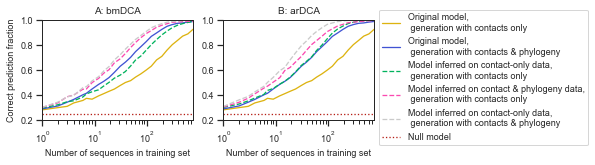

In [12]:
label_0 = "Original model,\n generation with contacts only"
label_1 = "Original model,\n generation with contacts & phylogeny"
label_2 =  "Model inferred on contact-only data,\n generation with contacts only"
label_3 = "Model inferred on contact & phylogeny data,\n generation with contacts only"
label_4 = "Model inferred on contact-only data,\n generation with contacts & phylogeny"
label_5 = "Model inferred on contact & phylogeny data,\n generation with contacts & phylogeny"
label_6 = "Null model"
xlabel = "Number of sequences in training set"
ylabel = "Correct prediction fraction"
ls_type = "--"
width = "article"
figsize = uti.set_size(width,subplots=(1,2))
fig, ax =  plt.subplots(figsize=figsize, ncols=2, nrows=1)


ax[0].set_title("A: bmDCA")
ax[0].plot(l_size_train, l_infered_no_phylo, color=cmaps[0], label=label_0)
ax[0].plot(l_size_train, l_infered_phylo, color=cmaps[1], label=label_1)
ax[0].plot(l_size_train, l_infered_no_phylo_bmDCA, color=cmaps[2], ls=ls_type, label=label_2)
ax[0].plot(l_size_train, l_phylo_infered_no_phylo_bmDCA, color=cmaps[4], ls=ls_type, label=label_3)
ax[0].plot(l_size_train, l_infered_phylo_bmDCA, ls=ls_type, color=cmaps[6], label=label_4)
#ax[1].plot(l_size_train, l_phylo_infered_phylo_bmDCA, ls = "--", color = cmaps[5], label = label_5)
ax[0].plot(l_size_train,[1/n_pair_species for i in l_size_train], color=cmaps[3], label=label_6, ls=ls_4)

ax[1].set_title("B: arDCA")
ax[1].plot(l_size_train, l_infered_no_phylo, color=cmaps[0],label=label_0)
ax[1].plot(l_size_train, l_infered_phylo, color=cmaps[1], label=label_1)
ax[1].plot(l_size_train, l_infered_no_phylo_arDCA, color=cmaps[2], ls=ls_type, label=label_2)
ax[1].plot(l_size_train, l_phylo_infered_no_phylo_arDCA, color=cmaps[4], ls=ls_type, label=label_3)
ax[1].plot(l_size_train, l_infered_phylo_arDCA, ls=ls_type, color=cmaps[6], label=label_4)
ax[1].plot(l_size_train,[1/n_pair_species for i in l_size_train], color=cmaps[3], label=label_6, ls=ls_4)
#ax[0].plot(l_size_train, l_phylo_infered_phylo_arDCA, ls = "--", color = cmaps[2], label = label_6)


ax[1].legend(bbox_to_anchor=(1, 1.15))
ax[0].set_ylim(0.2,1)
ax[1].set_ylim(0.2,1)
ax[0].semilogx()
ax[1].semilogx()
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)
ax[0].margins(x=0)
ax[1].margins(x=0)

#plt.savefig("figures/Inference_partners_mu=%s.eps"%(n_mutations_branch),bbox_inches = "tight")
plt.savefig("figures/S10_Inference_partners_mu=%s.eps"%(n_mutations_branch),bbox_inches = "tight")

## Score based on real model 

In [13]:
def Jij_aiaj(Graph):
    n = len(Graph)
    Jij = np.zeros((n,2,n,2))
    jContact = (-1*np.ones((2,2)) + np.diag([2,2]))/T
    jNoContact = np.zeros((2,2))/T
    for i in range(n):
        for j in range(i, n):
            if (i,j) in Graph.edges():
                Jij[i,:,j,:] = jContact
                Jij[j,:,i,:] = jContact
            else:
                Jij[i,:,j,:] = jNoContact
                Jij[j,:,i,:] = jNoContact
    return Jij

Jij = Jij_aiaj(Graph)

no_phylo, _ = inf_partner.inference_partner_generated(msa_no_phylo, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)
binary_tree_equi, _ = inf_partner.inference_partner_generated(msa_binary_tree_equi, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)

infered_no_phylo_arDCA, _ = inf_partner.inference_partner_generated(msa_infered_no_phylo_arDCA, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)
infered_phylo_arDCA, _ = inf_partner.inference_partner_generated(msa_infered_phylo_arDCA, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)
phylo_infered_no_phylo_arDCA, _ = inf_partner.inference_partner_generated(msa_phylo_infered_no_phylo_arDCA, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)
phylo_infered_phylo_arDCA, _ = inf_partner.inference_partner_generated(msa_phylo_infered_phylo_arDCA, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)

infered_no_phylo_bmDCA, _ = inf_partner.inference_partner_generated(msa_infered_no_phylo_bmDCA, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)
infered_phylo_bmDCA, _ = inf_partner.inference_partner_generated(msa_infered_phylo_bmDCA, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)
phylo_infered_no_phylo_bmDCA, _ = inf_partner.inference_partner_generated(msa_phylo_infered_no_phylo_bmDCA, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)
phylo_infered_phylo_bmDCA, _ = inf_partner.inference_partner_generated(msa_phylo_infered_phylo_bmDCA, 0, n_pair_species, pseudo_count, n_state_spin, middle_index, theta, graph=None, Jij_para=Jij)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


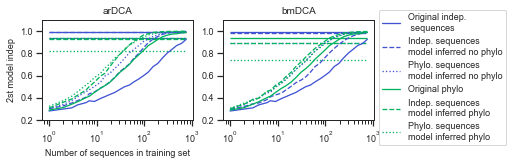

In [14]:
label_0 = "Original indep.\n sequences"
label_1 = "Original phylo"
label_2 =  "Indep. sequences\nmodel inferred no phylo"
label_3 = "Indep. sequences\nmodel inferred phylo"
label_4 =  "Phylo. sequences\nmodel inferred no phylo"
label_5 = "Phylo. sequences\nmodel inferred phylo"
xlabel = "Number of sequences in training set"
ylabel = "2st model indep"

width = "article"
figsize = uti.set_size(width,subplots=(1,2),scale_height=1)
fig, ax =  plt.subplots(figsize=figsize, nrows=1, ncols=2)

ax[0].plot(l_size_train, l_infered_no_phylo, color = cmaps[1],label = label_0)
ax[0].plot(l_size_train, l_infered_no_phylo_arDCA, color = cmaps[1], ls="--", label = label_2)
ax[0].plot(l_size_train, l_infered_phylo, color = cmaps[2], label = label_1)
ax[0].plot(l_size_train, l_phylo_infered_no_phylo_arDCA, color = cmaps[1], ls=":", label = label_4)
ax[0].plot(l_size_train, l_infered_phylo_arDCA, ls = "--", color = cmaps[2], label = label_3)
ax[0].plot(l_size_train, l_phylo_infered_phylo_arDCA, ls = ":", color = cmaps[2], label = label_5)
ax[0].set_title("arDCA")

ax[0].hlines( no_phylo,  l_size_train[0], l_size_train[-1], color = cmaps[1],label = label_0)
ax[0].hlines( binary_tree_equi,  l_size_train[0], l_size_train[-1], color = cmaps[2], label = label_1)

ax[0].hlines( infered_no_phylo_arDCA,  l_size_train[0], l_size_train[-1], color = cmaps[1], ls="--")
ax[0].hlines( phylo_infered_no_phylo_arDCA,  l_size_train[0], l_size_train[-1], color = cmaps[1], ls=":")
ax[0].hlines( infered_phylo_arDCA,  l_size_train[0], l_size_train[-1], ls = "--", color = cmaps[2])
ax[0].hlines( phylo_infered_phylo_arDCA,  l_size_train[0], l_size_train[-1], ls = ":", color = cmaps[2])
ax[0].set_title("arDCA")


ax[1].plot(l_size_train, l_infered_no_phylo, color = cmaps[1], label = label_0)
ax[1].plot(l_size_train, l_infered_no_phylo_bmDCA, color = cmaps[1], ls = "--", label = label_2)
ax[1].plot(l_size_train, l_phylo_infered_no_phylo_bmDCA, color = cmaps[1], ls = ":", label = label_4)
ax[1].plot(l_size_train, l_infered_phylo, color = cmaps[2], label = label_1)
ax[1].plot(l_size_train, l_infered_phylo_bmDCA, ls = "--", color = cmaps[2], label = label_3)
ax[1].plot(l_size_train, l_phylo_infered_phylo_bmDCA, ls = ":", color = cmaps[2], label = label_5)
ax[1].set_title("bmDCA")

ax[1].hlines( no_phylo,  l_size_train[0], l_size_train[-1], color = cmaps[1])
ax[1].hlines( binary_tree_equi,  l_size_train[0], l_size_train[-1], color = cmaps[2])

ax[1].hlines( infered_no_phylo_bmDCA,  l_size_train[0], l_size_train[-1], color = cmaps[1], ls="--")
ax[1].hlines( phylo_infered_no_phylo_bmDCA,  l_size_train[0], l_size_train[-1], color = cmaps[1], ls=":")
ax[1].hlines( infered_phylo_bmDCA,  l_size_train[0], l_size_train[-1], ls = "--", color = cmaps[2])
ax[1].hlines( phylo_infered_phylo_bmDCA,  l_size_train[0], l_size_train[-1], ls = ":", color = cmaps[2])

#ax[0].legend(bbox_to_anchor=(1, 1.15))
ax[0].set_ylim(0.2,1.1)
ax[0].semilogx()
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)

ax[1].legend(bbox_to_anchor=(1, 1.15))
ax[1].set_ylim(0.2,1.1)
ax[1].semilogx()
#ax[1][0].set_xlabel(xlabel)
#ax[1].set_ylabel(ylabel)


plt.savefig("figures/Inference_partners_phylo_line_model_base_infer.eps",bbox_inches = "tight",dpi=1000)

## Historigram $J_{i,j}$

In [15]:
def J_ij_reduction(J_ij_ai):
    return J_ij_ai[:,0,:,0]

def J_contact_no(J_ij, Graph):
    J_ij_red = J_ij_reduction(J_ij)
    l_con = []
    l_no_con = []
    
    for i in range(J_ij_red.shape[0]):
        for j in range(J_ij_red.shape[1]):
            if (i,j) in Graph.edges:
                l_con.append(J_ij_red[i,j])
            else:
                l_no_con.append(J_ij_red[i,j])
                
    return l_con, l_no_con

In [16]:
n_state_spin = 2
theta = 0.0
#ind_size_training = -1
l_Jij = [l_infered_no_phylo_Jij, l_infered_phylo_Jij, l_infered_no_phylo_arDCA_Jij,
         l_infered_phylo_arDCA_Jij, l_infered_no_phylo_bmDCA_Jij, l_infered_phylo_bmDCA_Jij]
l_msa = [msa_no_phylo, msa_binary_tree_equi, msa_infered_no_phylo_arDCA,
        msa_infered_phylo_arDCA, msa_infered_no_phylo_bmDCA, msa_infered_phylo_bmDCA]
l_name = ["Original indep.", "Original phylo.", "arDCA model\nfor indep.", 
          "arDCA model\nfor phylo.", "bmDCA model\nfor indep.", "bmDCA model\nfor phylo.",]
l_contact_and_no_contact = []

for J_ij in l_Jij:
    J_ij = J_ij[-1]
#for msa in l_msa:
    #J_ij = inf_partner.estimation_J_ij(msa, pseudo_count, n_state_spin, theta)
    l_con, l_no_con = J_contact_no(J_ij, Graph)
    l_contact_and_no_contact.append([l_con,l_no_con])

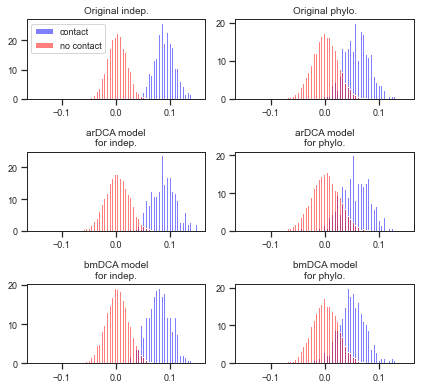

In [17]:
width = "article"
n_cols = 2
n_rows = int(len(l_contact_and_no_contact)/n_cols)
figsize = uti.set_size(width,subplots=(n_rows,n_cols))
fig, ax =  plt.subplots(figsize=figsize, ncols=n_cols, nrows=n_rows)
para_hist = {"bins":100, "range":(-0.15,0.15), "density":True }#{"bins":np.logspace(np.log10(0.01),np.log10(0.2), 50), "density":True, "stacked":False} #"bins":100 , "range":(0.01,1)

#ax[0][0].set_title("$|J_{ij}|$ contact")
#ax[0][1].set_title("$|J_{ij}|$ no contact")
for i, (l_con, l_no_con) in enumerate(l_contact_and_no_contact):
    ax[i//n_cols][i%n_cols].set_title(l_name[i])
    ax[i//n_cols][i%n_cols].hist(l_con, fc=(0, 0, 1, 0.5), **para_hist,  label="contact")
    ax[i//n_cols][i%n_cols].hist(l_no_con, fc=(1, 0, 0, 0.5), **para_hist, label="no contact")
    #ax[i//n_cols][i%n_cols].set_xscale("log")
ax[0][0].legend()
plt.tight_layout()
plt.savefig("figures/histo_J_ij.png",bbox_inches = "tight", dpi=1000)

In [18]:
n_state_spin = 2
theta = 0.0
#ind_size_training = -1
l_Jij = [l_infered_no_phylo_Jij, l_infered_phylo_Jij, l_phylo_infered_no_phylo_arDCA_Jij,
         l_phylo_infered_phylo_arDCA_Jij, l_phylo_infered_no_phylo_bmDCA_Jij, l_phylo_infered_phylo_bmDCA_Jij]
l_name = ["Original indep.", "Original phylo.", "phylo arDCA model\nfor indep.", 
          "phylo arDCA model\nfor phylo.", "phylo bmDCA model\nfor indep.", "phylo bmDCA model\nfor phylo.",]
l_contact_and_no_contact = []

for J_ij in l_Jij:
    J_ij = J_ij[-1]
    l_con, l_no_con = J_contact_no(J_ij, Graph)
    l_contact_and_no_contact.append([l_con,l_no_con])

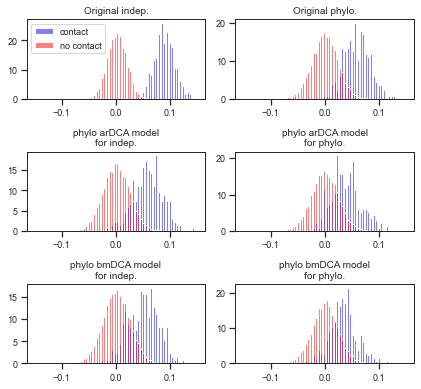

In [19]:
width = "article"
n_cols = 2
n_rows = int(len(l_contact_and_no_contact)/n_cols)
figsize = uti.set_size(width,subplots=(n_rows,n_cols))
fig, ax =  plt.subplots(figsize=figsize, ncols=n_cols, nrows=n_rows)
para_hist = {"bins":100, "range":(-0.15,0.15), "density":True }#{"bins":np.logspace(np.log10(0.01),np.log10(0.2), 50), "density":True, "stacked":False} #"bins":100 , "range":(0.01,1)

#ax[0][0].set_title("$|J_{ij}|$ contact")
#ax[0][1].set_title("$|J_{ij}|$ no contact")
for i, (l_con, l_no_con) in enumerate(l_contact_and_no_contact):
    ax[i//n_cols][i%n_cols].set_title(l_name[i])
    ax[i//n_cols][i%n_cols].hist(l_con, fc=(0, 0, 1, 0.5), **para_hist,  label="contact")
    ax[i//n_cols][i%n_cols].hist(l_no_con, fc=(1, 0, 0, 0.5), **para_hist, label="no contact")
    #ax[i//n_cols][i%n_cols].set_xscale("log")
ax[0][0].legend()
plt.tight_layout()
plt.savefig("figures/histo_J_ij_phylo.png",bbox_inches = "tight", dpi=1000)

## Check reproduction frequencies

In [20]:
def one_freq(Fij):
    Fi = np.zeros((Fij.shape[0],Fij.shape[1]))
    for site in range(Fi.shape[0]):
        for sp in range(Fi.shape[1]):
            Fi[site,sp] = Fij[site,sp,site,sp]
    return Fi

A: bmDCA
 a+b*x:[0.01 0.96]
 pearson = 0.8632
B: arDCA
 a+b*x:[0.   0.99]
 pearson = 0.8687


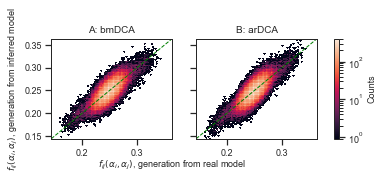

In [21]:
import importlib
importlib.reload(an)
importlib.reload(ut)
importlib.reload(ut)

theta = 0.2
n_states = 2
pseudo_count = 0

Fij_original_no_phylo,_ = an.two_body_freq_cython(msa_no_phylo, pseudo_count, n_states, theta)
Fij_arDCA_no_phylo,_ = an.two_body_freq_cython(msa_infered_no_phylo_arDCA, pseudo_count, n_states, 0)
Fij_bmDCA_no_phylo,_ = an.two_body_freq_cython(msa_infered_no_phylo_bmDCA, pseudo_count, n_states, 0)

l_Fij_ref = np.array([Fij_original_no_phylo, Fij_original_no_phylo])
l_Fij_calc = np.array([Fij_bmDCA_no_phylo, Fij_arDCA_no_phylo])

l_title = ["A: bmDCA", "B: arDCA"]
l_axes_title = ["$f_{i j}(\\alpha_i,\\alpha_j)$, generation from real model", "$f_{ij}(\\alpha_i,\\alpha_j)$, generation from inferred model"]
l_hh = ut.polt_two_l_freq(l_Fij_ref, l_Fij_calc, l_axes_title, l_title=l_title, width="article")
plt.savefig("figures/2_frequences_no_phylo_VS_no_phylo_infered_no_phylo.png",bbox_inches="tight", dpi=500)

A: bmDCA
 a+b*x:[0.03 0.94]
 pearson = 0.6492
B: arDCA
 a+b*x:[-0.01  1.02]
 pearson = 0.6783


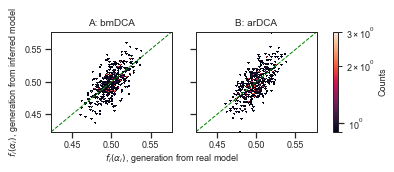

In [22]:
Fi_original_no_phylo = one_freq(Fij_original_no_phylo)
Fi_arDCA_no_phylo = one_freq(Fij_arDCA_no_phylo)
Fi_bmDCA_no_phylo = one_freq(Fij_bmDCA_no_phylo)

l_Fi_ref = np.array([Fi_original_no_phylo, Fi_original_no_phylo])
l_Fi_calc = np.array([Fi_bmDCA_no_phylo, Fi_arDCA_no_phylo])

l_title = ["A: bmDCA", "B: arDCA"]
l_axes_title = ["$f_{i}(\\alpha_i)$, generation from real model", "$f_{i}(\\alpha_i)$, generation from inferred model"]
l_hh = ut.polt_two_l_freq(l_Fi_ref, l_Fi_calc, l_axes_title, l_title=l_title, width="article", one_freq=True)
plt.savefig("figures/1_frequence_no_phylo_VS_no_phylo_infered_no_phylo.png",bbox_inches="tight", dpi=500)

In [23]:
msa_no_phylo.shape

(1024, 200)

A: bmDCA
 a+b*x:[0.01 0.96]
 pearson = 0.9954
B: arDCA
 a+b*x:[0. 1.]
 pearson = 0.9959


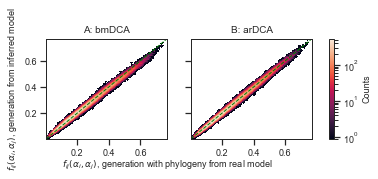

In [24]:
Fij_original_phylo,_ = an.two_body_freq_cython(msa_binary_tree_equi, pseudo_count, n_states, theta)
Fij_arDCA_phylo,_ = an.two_body_freq_cython(msa_infered_phylo_arDCA, pseudo_count, n_states, 0)
Fij_bmDCA_phylo,_ = an.two_body_freq_cython(msa_infered_phylo_bmDCA, pseudo_count, n_states, 0)

l_Fij_ref = np.array([Fij_original_phylo, Fij_original_phylo])
l_Fij_calc = np.array([Fij_bmDCA_phylo, Fij_arDCA_phylo])

l_title = ["A: bmDCA", "B: arDCA"]
l_axes_title = ["$f_{i j}(\\alpha_i,\\alpha_j)$, generation with phylogeny from real model", "$f_{ij}(\\alpha_i,\\alpha_j)$, generation from inferred model"]
l_hh = ut.polt_two_l_freq(l_Fij_ref, l_Fij_calc, l_axes_title, l_title=l_title, width="article")
plt.savefig("figures/2_frequences_phylo_VS_no_phylo_infered_on_phylo.png", bbox_inches="tight", dpi=500)

A: bmDCA
 a+b*x:[0.02 0.96]
 pearson = 0.997
B: arDCA
 a+b*x:[0. 1.]
 pearson = 0.9973


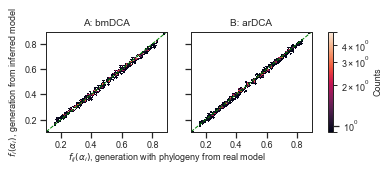

In [25]:
Fi_original_no_phylo = one_freq(Fij_original_phylo)
Fi_arDCA_no_phylo = one_freq(Fij_arDCA_phylo)
Fi_bmDCA_no_phylo = one_freq(Fij_bmDCA_phylo)

l_Fi_ref = np.array([Fi_original_no_phylo, Fi_original_no_phylo])
l_Fi_calc = np.array([Fi_bmDCA_no_phylo,Fi_arDCA_no_phylo])

l_title = ["A: bmDCA", "B: arDCA"]
l_axes_title = ["$f_{i j}(\\alpha_i)$, generation with phylogeny from real model", "$f_{i}(\\alpha_i)$, generation from inferred model"]
l_hh = ut.polt_two_l_freq(l_Fi_ref, l_Fi_calc, l_axes_title, l_title=l_title, width="article", one_freq=True)
plt.savefig("figures/1_frequence_phylo_VS_no_phylo_infered_on_phylo.png",bbox_inches="tight", dpi=500)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


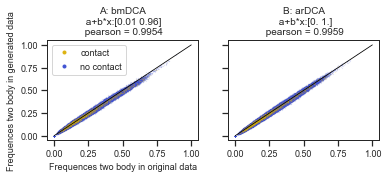

In [26]:
ut.polt_two_l_freq_contact(l_Fij_ref, l_Fij_calc, Graph, cmaps, l_title=l_title, width="article")
plt.savefig("figures/frequences_contact.eps",bbox_inches = "tight")

## Delete false contact in score

In [27]:
msa_no_phylo = np.load("data_genereted_after_inference/msa_no_phylo.npy")
msa_binary_tree_equi = np.load("data_genereted_after_inference/msa_binary_tree_equi.npy")

## arDCA ##
path_save_msa = "data_genereted_after_inference/msa_infered_no_phylo_arDCA.fasta.npy"
msa_infered_no_phylo_arDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_infered_phylo_arDCA.fasta.npy"
msa_infered_phylo_arDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_phylo_infered_no_phylo_arDCA.fasta.npy"
msa_phylo_infered_no_phylo_arDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_phylo_infered_phylo_arDCA.fasta.npy"
msa_phylo_infered_phylo_arDCA = np.load(path_save_msa)

## bmDCA ##
path_save_msa = "data_genereted_after_inference/msa_infered_no_phylo_bmDCA.fasta.npy"
msa_infered_no_phylo_bmDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_infered_phylo_bmDCA.fasta.npy"
msa_infered_phylo_bmDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_phylo_infered_no_phylo_bmDCA.fasta.npy"
msa_phylo_infered_no_phylo_bmDCA = np.load(path_save_msa)

path_save_msa = "data_genereted_after_inference/msa_phylo_infered_phylo_bmDCA.fasta.npy"
msa_phylo_infered_phylo_bmDCA = np.load(path_save_msa)


size_train_max = int(1.5*2**(n_generations-1))
regularisation = pseudo_count
number_of_pair_in_species = n_pair_species
n_state_spin = 2
middle_index = 100
theta = 0

l_size_train = np.unique(np.geomspace(100, size_train_max, num=30, dtype=int))
args = [l_size_train, number_of_pair_in_species, 
        regularisation, n_state_spin, middle_index, theta, Graph]

l_infered_no_phylo_true_contact, l_infered_no_phylo_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_no_phylo, *args)

l_infered_phylo_true_contact, l_infered_phylo_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_binary_tree_equi, *args)

## arDCA ##
l_infered_no_phylo_arDCA_true_contact, l_infered_no_phylo_arDCA_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_infered_no_phylo_arDCA, *args)

l_infered_phylo_arDCA_true_contact, l_infered_phylo_arDCA_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_infered_phylo_arDCA, *args)

l_phylo_infered_no_phylo_arDCA_true_contact, l_phylo_infered_no_phylo_arDCA_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_phylo_infered_no_phylo_arDCA, *args)

l_phylo_infered_phylo_arDCA_true_contact, l_phylo_infered_phylo_arDCA_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_phylo_infered_phylo_arDCA, *args)

## bmDCA ##
l_infered_no_phylo_bmDCA_true_contact, l_infered_no_phylo_bmDCA_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_infered_no_phylo_bmDCA, *args)

l_infered_phylo_bmDCA_true_contact, l_infered_phylo_bmDCA_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_infered_phylo_bmDCA, *args)

l_phylo_infered_no_phylo_bmDCA_true_contact, l_phylo_infered_no_phylo_bmDCA_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_phylo_infered_no_phylo_bmDCA, *args)

l_phylo_infered_phylo_bmDCA_true_contact, l_phylo_infered_phylo_bmDCA_Jij_true_contact = inf_partner.l_plot_inference_true_contact(msa_phylo_infered_phylo_bmDCA, *args)

0.0  %
20.0  %
40.0  %
60.0  %
80.0  %
0.0  %
20.0  %
40.0  %
60.0  %
80.0  %
0.0  %
20.0  %
40.0  %
60.0  %
80.0  %
0.0  %
20.0  %
40.0  %
60.0  %
80.0  %
0.0  %
20.0  %
40.0  %
60.0  %
80.0  %
0.0  %


LinAlgError: singular matrix

In [ ]:
label_0 = "Original indep.\n sequences"
label_1 = "Original phylo"
label_2 =  "Indep. sequences\nmodel inferred no phylo"
label_3 = "Indep. sequences\nmodel inferred phylo"
label_4 =  "Phylo. sequences\nmodel inferred no phylo"
label_5 = "Phylo. sequences\nmodel inferred phylo"
xlabel = "Number of sequences in training set"
ylabel = "2st model indep"

width = "article"
figsize = uti.set_size(width,subplots=(1,2),scale_height=1)
fig, ax =  plt.subplots(figsize=figsize, nrows=1, ncols=2)

ax[0].plot(l_size_train, l_infered_no_phylo_true_contact, color = cmaps[1],label = label_0)
ax[0].plot(l_size_train, l_infered_no_phylo_arDCA_true_contact, color = cmaps[1], ls="--", label = label_2)
ax[0].plot(l_size_train, l_infered_phylo_true_contact, color = cmaps[2], label = label_1)
ax[0].plot(l_size_train, l_phylo_infered_no_phylo_arDCA_true_contact, color = cmaps[1], ls=":", label = label_4)
ax[0].plot(l_size_train, l_infered_phylo_arDCA_true_contact, ls = "--", color = cmaps[2], label = label_3)
ax[0].plot(l_size_train, l_phylo_infered_phylo_arDCA_true_contact, ls = ":", color = cmaps[2], label = label_5)
ax[0].set_title("arDCA")


ax[1].plot(l_size_train, l_infered_no_phylo_true_contact, color = cmaps[1], label = label_0)
ax[1].plot(l_size_train, l_infered_no_phylo_bmDCA_true_contact, color = cmaps[1], ls = "--", label = label_2)
ax[1].plot(l_size_train, l_phylo_infered_no_phylo_bmDCA_true_contact, color = cmaps[1], ls = ":", label = label_4)
ax[1].plot(l_size_train, l_infered_phylo_true_contact, color = cmaps[2], label = label_1)
ax[1].plot(l_size_train, l_infered_phylo_bmDCA_true_contact, ls = "--", color = cmaps[2], label = label_3)
ax[1].plot(l_size_train, l_phylo_infered_phylo_bmDCA_true_contact, ls = ":", color = cmaps[2], label = label_5)
ax[1].set_title("bmDCA")

#ax[0].legend(bbox_to_anchor=(1, 1.15))
ax[0].set_ylim(0.2,1)
ax[0].set_ylim(0.2,1)
ax[0].semilogx()
ax[0].semilogx()
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)

ax[1].legend(bbox_to_anchor=(1, 1.15))
ax[1].set_ylim(0.2,1)
ax[1].set_ylim(0.2,1)
ax[1].semilogx()
ax[1].semilogx()
#ax[1][0].set_xlabel(xlabel)
ax[1].set_ylabel(ylabel)

plt.savefig("figures/Inference_partners_phylo_only_contact.eps",bbox_inches = "tight",dpi=1000)

## Comparaison données d'équilibre vs. données générées avec phylo à partir du modèle inféré sur les données d'équilibre

In [ ]:
msa_no_phylo = np.load("data_genereted_after_inference/msa_no_phylo.npy")

#path_file_coupling = "bmDCA_2_states/OutputFolder_msa_no_phylo.fasta/parameters_learnt_2000.txt"
path_file_coupling = file_name_no_phylo[:-6] + "/parameters_final.txt"
n_mutations_branch_2 = 10
path_save_msa = "data_genereted_after_inference/msa_phylo_mu=%s_infered_no_phylo_bmDCA.fasta"%n_mutations_branch_2
msa_phylo_infered_no_phylo_bmDCA_2 = ge_bmDCA.generate_sequences_bmDCA_phylo(path_file_coupling, path_save_msa, n_generations, n_mutations_branch_2, Flip_equi)

path_save_msa = "data_genereted_after_inference/msa_phylo_infered_no_phylo_bmDCA.fasta.npy"
msa_phylo_infered_no_phylo_bmDCA = np.load(path_save_msa)

theta = 0.2
n_states = 2

Fij_original_no_phylo,_ = an.two_body_freq_cython(msa_no_phylo, pseudo_count, n_states, theta)
Fij_in_bmDCA_phylo,_ = an.two_body_freq_cython(msa_phylo_infered_no_phylo_bmDCA, pseudo_count, n_states, theta)
Fij_in_bmDCA_phylo_2,_ = an.two_body_freq_cython(msa_phylo_infered_no_phylo_bmDCA_2, pseudo_count, n_states, theta)

l_Fij_ref = [Fij_original_no_phylo, Fij_original_no_phylo]
l_Fij_calc = [Fij_in_bmDCA_phylo_2, Fij_in_bmDCA_phylo]

l_axes = ["", ""]
l_title = [ "bmDCA mu=%s"%n_mutations_branch_2, "bmDCA mu=%s"%n_mutations_branch ]
ut.polt_two_l_freq(l_Fij_ref, l_Fij_calc,l_axes, l_title=l_title, width="article")
plt.savefig("figures/frequences_mu.eps",bbox_inches = "tight", dpi=500)

In [ ]:
ut.polt_two_l_freq_contact(l_Fij_ref, l_Fij_calc, Graph, cmaps, l_title=l_title, width="article")
plt.savefig("figures/frequences_mu_contact.eps",bbox_inches = "tight", dpi=500)